In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import QuantileTransformer

from models.resnet import ResNet

pl.seed_everything(1, workers=True)

Seed set to 1


1

In [2]:
X = pd.read_csv("data/train_enc.csv")
y = pd.read_csv("data/y_train.csv")

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=1,
    )

In [3]:
def prepare_dataloaders(X: pd.DataFrame, 
                        y: pd.DataFrame, 
                        test_size: float = 0.1, 
                        seed: int = 1, 
                        batch_size: int = 128):

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=seed,
    )

    X_train = torch.from_numpy(X_train.values.astype(np.float32)).float()
    y_train = torch.from_numpy(y_train.values.astype(np.float32)).float().squeeze(-1)

    X_val = torch.from_numpy(X_val.values.astype(np.float32)).float()
    y_val = torch.from_numpy(y_val.values.astype(np.float32)).float().squeeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=27)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=27)

    return train_loader, val_loader

In [4]:
def fit(X: pd.DataFrame, y: pd.DataFrame, params: dict = {}, seed: int = None):
    train_loader, val_loader = prepare_dataloaders(X, y)

    model = ResNet(X.shape[1], params)

    trainer = pl.Trainer(
        max_epochs=50,

        callbacks=[
            pl.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=15, min_delta=1e-4),
            pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_f1", mode="max"),
        ],
        accelerator="auto",
        enable_checkpointing=True,
        logger=True
    )

    trainer.fit(model, train_loader, val_loader)

    return model

def predict(model: torch.nn.Module, X_test: pd.DataFrame, threshold: float = 0.5) -> np.ndarray:

    model.eval()

    test_loader = DataLoader(torch.from_numpy(X_test.values.astype(np.float32)).float(),batch_size=700)

    predictions = []
    with torch.no_grad():
        for x in test_loader:
            y_pred = model(x)
            predictions.append(y_pred.cpu().numpy())
            
    predicted_proba = np.concatenate(predictions)
    predicted_labels = (predicted_proba >= threshold).astype(np.int8)

    return predicted_labels

In [5]:
X_test

,Age_at_diagnosis,asian,black or african american,Female,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
444,2.751009,False,False,False,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
495,1.338369,False,False,True,0,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
544,-0.631869,False,False,False,0,0,1,1,1,1,...,1,1,1,1,0,0,1,1,1,1
568,-0.651664,False,False,False,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
201,-0.427517,False,False,False,0,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,-0.541902,False,False,False,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
135,-0.334810,False,False,True,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
62,0.566887,False,False,False,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
396,0.770013,False,False,False,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [6]:
model = fit(X_train, y_train) 
predictions = predict(model, X_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kate/miniconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | BCELoss       | 0      | train
1 | f1         | BinaryF1Score | 0      | train
2 | blocks     | Sequential    | 136 K  | train
3 | prediction | Sequential    | 385    | train
------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kate/miniconda3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [7]:
f1 = f1_score(y_test.values, predictions)
f1

0.7857142857142857

In [8]:
scaler = QuantileTransformer(n_quantiles=20, output_distribution='normal')
scaler.fit(X[['Age_at_diagnosis']])

X_train[['Age_at_diagnosis']] = scaler.transform(X_train[['Age_at_diagnosis']])
X_test[['Age_at_diagnosis']] = scaler.transform(X_test[['Age_at_diagnosis']])

model = fit(X_train, y_train) 
predictions = predict(model, X_test)

f1 = f1_score(y_test.values, predictions)
f1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | BCELoss       | 0      | train
1 | f1         | BinaryF1Score | 0      | train
2 | blocks     | Sequential    | 136 K  | train
3 | prediction | Sequential    | 385    | train
-----------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.548     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kate/miniconda3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

0.8

In [9]:
selected_features = ["IDH1", "CIC", "FUBP1", "Age_at_diagnosis", "RB1"]

X_train = X_train[selected_features]
X_test = X_test[selected_features]

model = fit(X_train, y_train) 
predictions = predict(model, X_test)

f1 = f1_score(y_test.values, predictions)
f1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | BCELoss       | 0      | train
1 | f1         | BinaryF1Score | 0      | train
2 | blocks     | Sequential    | 134 K  | train
3 | prediction | Sequential    | 385    | train
-----------------------------------------------------
134 K     Trainable params
0         Non-trainable params
134 K     Total params
0.538     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kate/miniconda3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

0.8135593220338984

In [10]:
def fit_and_test(X, y, train_index, test_index, config = {}) -> float:
    X_train_ = X.loc[train_index,:]
    X_test_ = X.loc[test_index,:]
    y_train_ = y.loc[train_index, :]
    y_test_ = y.loc[test_index, :]

    model = fit(X_train_, y_train_, config)
    preds = predict(model, X_test_)
    
    return f1_score(y_test_, preds)

In [24]:
def objective(trial):
    config = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1,log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2,log=True),
        'n_hidden':trial.suggest_int('n_hidden', 2, 5),
        'layer_size': trial.suggest_int('layer_size', 8, 512, log=True),
        'batch_size': trial.suggest_int('batch_size', 32, 2048, log=True),
        'normalization': trial.suggest_categorical('normalization', choices=['layer_norm', 'batch_norm']),
        'dropout': trial.suggest_categorical('dropout', choices=['dropout', 'dropout1d']),
        'activation': trial.suggest_categorical('activation', choices=['relu', 'gelu']), 
        'use_scheduler': trial.suggest_categorical('use_scheduler', choices=['True', 'False']), 
        'hidden_factor': trial.suggest_float('hidden_factor', 1, 4),
        'hidden_dropout': trial.suggest_float('hidden_dropout', 0, 0.5),
        'residual_dropout': trial.suggest_float('residual_dropout', 0, 0.5),
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    scores = []
    for i,(train_index,test_index) in enumerate(cv.split(X_train, y_train)):

        f1_score = fit_and_test(X_train, y_train, train_index, test_index, config)
        scores.append(f1_score)
    
    return np.mean(scores)

study = optuna.create_study(directions=['maximize'], study_name='mlp')
study.optimize(objective, n_trials=50) 

In [11]:
best_params =  {'learning_rate': 0.010820593737363857,
 'weight_decay': 0.0028708446665428656,
 'n_hidden': 2,
 'layer_size': 107,
 'batch_size': 329,
 'normalization': 'layer_norm',
 'dropout': 'dropout',
 'activation': 'relu',
 'use_scheduler': 'True',
 'hidden_factor': 3.0936187623304567,
 'hidden_dropout': 0.4581803981076345,
 'residual_dropout': 0.4958419174044564}

In [12]:
model = fit(X_train, y_train, best_params)
 
predictions = predict(model, X_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | BCELoss       | 0      | train
1 | f1         | BinaryF1Score | 0      | train
2 | blocks     | Sequential    | 144 K  | train
3 | prediction | Sequential    | 322    | train
-----------------------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.581     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/kate/miniconda3/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [94]:
f1 = f1_score(y_test, predictions)
f1

0.8571428571428571

<Figure size 800x600 with 0 Axes>

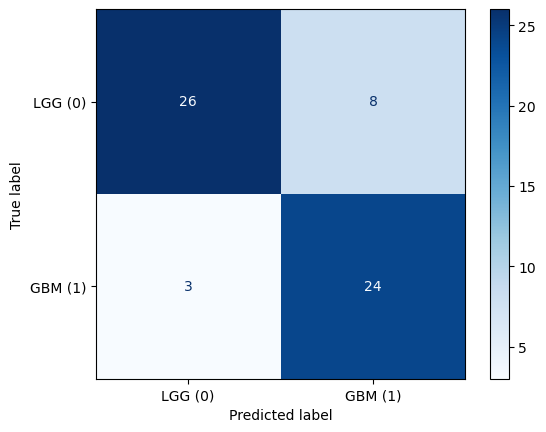

In [13]:
confusion_m = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_m, display_labels=['LGG (0)', 'GBM (1)']).plot(cmap='Blues')
plt.show();

In [ ]:
n_ensemble = 3
threshold = 0.5
predictions_list = []

X_y = X_train.join(y_train)

for i in range(n_ensemble):
    seed = n_ensemble * i
    df_resampled = resample(X_y, replace=False, random_state=seed)

    target = df_resampled["Grade"]
    train = df_resampled.drop("Grade", axis=1)

    model = fit(train, target, best_params, seed=seed)
    preds = predict(model, X_test)
    
    predictions_list.append(preds)

In [21]:
final_prediction = np.mean(predictions_list, axis=0)
f1 = f1_score(y_test, final_prediction)
f1

0.8135593220338984

<Figure size 800x600 with 0 Axes>

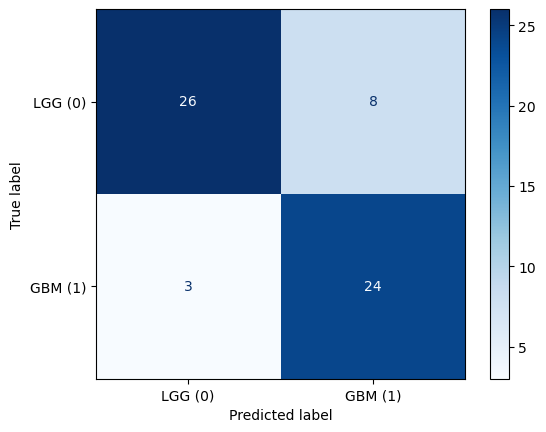

In [100]:
confusion_m = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_m, display_labels=['LGG (0)', 'GBM (1)']).plot(cmap='Blues')
plt.show();